In [20]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras.layers import Dense
import datetime
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import keras_cv
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Preprocessing**

In [2]:
(train_ds, test_ds) = tfds.load('mnist', split =['train', 'test'], as_supervised = True)
def prepare(data, batch_size, sequence_length):
    data = data.map(lambda x, t: (tf.cast(x, tf.float32), tf.cast(t, dtype=tf.dtypes.int32)))
    data = data.map(lambda x, t: ((x/128.)-1., t))
    data = data.window(sequence_length, drop_remainder=True) #windowing

    scan_function = lambda state, i: (state*-1, state*i) #alternating signs
    scan_function_2 = lambda state, i: (state+i, state+i) #cumulative sum

    data = data.map(lambda img, label: (img, label.scan(initial_state=1, scan_func=scan_function)))
    data = data.map(lambda img, label: (img, label.scan(initial_state=0, scan_func=scan_function_2)))

    data = data.map(lambda img, label: (img.batch(sequence_length).get_single_element(), label.batch(sequence_length).get_single_element()))

    data = data.shuffle(1000)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

train_data = prepare(train_ds, 32, 4)
test_data = prepare(test_ds, 32, 4)

print(train_data)

for a,b in train_data.take(1):
    print("img shape: ", a.shape, "\nlabel shape: ", b.shape)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>
img shape:  (32, 4, 28, 28, 1) 
label shape:  (32, 4)


**Convolutional Model**

In [3]:
class ConvModel(tf.keras.Model):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.ConvLayer1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="valid", activation="relu", input_shape=(28, 28, 1))
        self.Pool1 = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2,strides=2))
        self.BatchNorm1 = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())
        self.ConvLayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu')
        self.Pool2= tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAvgPool2D())
        self.Dropout1 = tf.keras.layers.Dropout(0.5)
        self.out = tf.keras.layers.Dense(10, activation='softmax')
    
    def call(self,x):
        x = self.ConvLayer1(x)
        x = self.Pool1(x)
        x = self.BatchNorm1(x)
        x = self.ConvLayer2(x)
        x = self.Pool2(x)
        x = self.Dropout1(x)
        x = self.out(x)
        return x


**LSTM Cell**

In [4]:
class LSTMModel(tf.keras.layers.AbstractRNNCell):
    def __init__(self, units, **kwargs):
        super(LSTMModel, self).__init__(**kwargs)
        self.units = units

        self.forget_gate = tf.keras.layers.Dense(units,
                                                 kernel_initializer=tf.keras.initializers.Orthogonal(),
                                                 activation=tf.nn.sigmoid)
        self.input_gate = tf.keras.layers.Dense(units,
                                                kernel_initializer=tf.keras.initializers.Orthogonal(),
                                                activation=tf.nn.sigmoid)
        self.candidate_gate = tf.keras.layers.Dense(units,
                                                    kernel_initializer=tf.keras.initializers.Orthogonal(),
                                                    activation=tf.nn.tanh)
        self.output_gate = tf.keras.layers.Dense(units,
                                                 kernel_initializer=tf.keras.initializers.Orthogonal(),
                                                 activation=tf.nn.sigmoid)

    @property
    def state_size(self):
        return [tf.TensorShape([self.units]), tf.TensorShape([self.units])]

    @property
    def output_size(self):
        return [tf.TensorShape([self.units])]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([batch_size, self.units]), tf.zeros([batch_size, self.units])]

    def call(self, inputs, states):
        x = tf.concat([states[0], inputs], -1)
  
        forget = self.forget_gate(x)
        input = self.input_gate(x)
        candidate = self.candidate_gate(x)
        output = self.output_gate(x)

        cell_state = forget*states[1] + input*candidate
        hidden_state = output*tf.math.tanh(cell_state)
        
        return hidden_state, [hidden_state, cell_state]


**RNN Model**

In [15]:
class RNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.conv = ConvModel()
        self.lstm = LSTMModel(32)
        self.lstm = tf.keras.layers.LSTMCell(32)
        self.rnn = tf.keras.layers.RNN(self.lstm, return_sequences=True, unroll=False)
        self.dense = tf.keras.layers.Dense(1)

        self.metrics_list = [tf.keras.metrics.Mean(name="loss"), tf.keras.metrics.CategoricalAccuracy(name="accuracy")]

    def call(self, x, training=False, **kwargs):
        x = self.conv(x)
        x = self.rnn(x)
        x = self.dense(x)
        return x

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()

    def train_step(self, data):
        sequence, label = data
        with tf.GradientTape() as tape:
            output = self(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        sequence, label = data
        output = self(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(label, output)

        return {m.name: m.result() for m in self.metrics}

**Training**

In [17]:
model = RNNModel()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
history = model.fit(train_data, validation_data=test_data, epochs=25)


Epoch 1/25
469/469 [==============================] - 21s 40ms/step - loss: 26.6948 - accuracy: 0.2525 - val_loss: 24.8465 - val_accuracy: 0.4488
Epoch 2/25
469/469 [==============================] - 21s 44ms/step - loss: 24.3667 - accuracy: 0.4496 - val_loss: 21.3598 - val_accuracy: 0.4488
Epoch 3/25
469/469 [==============================] - 17s 35ms/step - loss: 21.0347 - accuracy: 0.4599 - val_loss: 20.6566 - val_accuracy: 0.5512
Epoch 4/25
469/469 [==============================] - 15s 30ms/step - loss: 20.8764 - accuracy: 0.5009 - val_loss: 20.4461 - val_accuracy: 0.5512
Epoch 5/25
469/469 [==============================] - 16s 34ms/step - loss: 20.8757 - accuracy: 0.5126 - val_loss: 20.4330 - val_accuracy: 0.5512
Epoch 6/25
469/469 [==============================] - 15s 32ms/step - loss: 20.8684 - accuracy: 0.5002 - val_loss: 20.5932 - val_accuracy: 0.5512
Epoch 7/25
469/469 [==============================] - 15s 30ms/step - loss: 19.6291 - accuracy: 0.5733 - val_loss: 18.2074 -

In [18]:
model.save("rnn_model")

INFO:tensorflow:Assets written to: rnn_model\assets


INFO:tensorflow:Assets written to: rnn_model\assets


**Visualization**

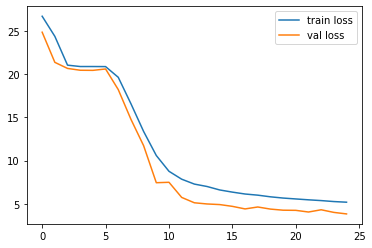

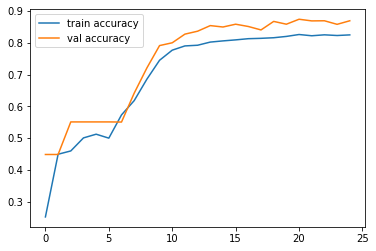

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels=["train loss", "val loss"])
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(labels=["train accuracy", "val accuracy"])
plt.show()

In [ ]:
%tensorboard --logdir logs/


Reusing TensorBoard on port 6006 (pid 7456), started 1 day, 17:29:57 ago. (Use '!kill 7456' to kill it.)